## 0. Download dataset
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [1]:
# https://drive.google.com/file/d/1kc6XNqHZJg27KeBuoAoYj70_1rT92191/view?usp=sharing
!gdown --id 1kc6XNqHZJg27KeBuoAoYj70_1rT92191

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191
To: /content/vqa_coco_dataset.zip
100% 196M/196M [00:02<00:00, 90.6MB/s]


In [2]:
!unzip -q vqa_coco_dataset.zip

## 1. Import libraries

In [1]:
!pip install timm -q

In [2]:
import torch
import torch.nn as nn
import torchtext
import os
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms

## 2. Read dataset

In [3]:
train_data = []
train_set_path = './vaq2.0.TrainImages.txt'

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        train_data.append(data_sample)

In [4]:
val_data = []
val_set_path = './vaq2.0.DevImages.txt'

with open(val_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        val_data.append(data_sample)

In [5]:
test_data = []
test_set_path = './vaq2.0.TestImages.txt'

with open(test_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        test_data.append(data_sample)

## 3. Data Preprocessing

In [6]:
eng = spacy.load("en_core_web_sm") # Load the English model to tokenize English text

def get_tokens(data_iter):
    for sample in data_iter:
        question = sample['question']

        yield [token.text for token in eng.tokenizer(question)]


vocab = build_vocab_from_iterator(
    get_tokens(train_data),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])

In [7]:
len(vocab)

1678

In [8]:
def tokenize(question, max_seq_len):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = [vocab[token] for token in tokens]
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]

    return sequence

In [9]:
example_question = "Is this a picture of an apple?"
max_seq_len = 20

tokenize(example_question, max_seq_len)

[6, 5, 7, 16, 21, 75, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [10]:
classes = set([sample['answer'] for sample in train_data])
classes_to_idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx_to_classes = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}
print(idx_to_classes)

{0: 'yes', 1: 'no'}


## 4. Create Pytorch dataset

In [11]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        classes_to_idx,
        max_seq_len=20,
        transform=None,
        root_dir='/content/val2014-resised/'
    ):
        self.transform = transform
        self.data = data
        self.max_seq_len = max_seq_len
        self.root_dir = root_dir
        self.classes_to_idx = classes_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        question = self.data[index]['question']
        question = tokenize(question, self.max_seq_len)
        question = torch.tensor(question, dtype=torch.long)

        label = self.data[index]['answer']
        label = classes_to_idx[label]
        label = torch.tensor(label, dtype=torch.long)

        return img, question, label

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [13]:
train_dataset = VQADataset(
    train_data,
    classes_to_idx=classes_to_idx,
    transform=transform
)
val_dataset = VQADataset(
    val_data,
    classes_to_idx=classes_to_idx,
    transform=transform
)
test_dataset = VQADataset(
    test_data,
    classes_to_idx=classes_to_idx,
    transform=transform
)

In [14]:
train_batch_size = 128
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

## 5. Create Model

In [15]:
class VQAModel(nn.Module):
    def __init__(
        self,
        n_classes,
        img_model_name='resnet50',
        embeddding_dim=300,
        n_layers=1,
        hidden_size=128,
        dropout_prob=0.2
    ):
        super(VQAModel, self).__init__()
        self.image_encoder = timm.create_model(
            img_model_name,
            pretrained=True,
            num_classes=hidden_size
        )

        self.embedding = nn.Embedding(len(vocab), embeddding_dim)
        self.lstm1 = nn.LSTM(
            input_size=embeddding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.lstm2 = nn.LSTM(
            input_size=hidden_size*3,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size * 2, n_classes)

    def forward(self, img, text):
        img_features = self.image_encoder(img)

        text_emb = self.embedding(text)
        lstm_out, _ = self.lstm1(text_emb)

        lstm_out = lstm_out[:, -1, :]

        combined = torch.cat((img_features, lstm_out), dim=1)
        x, _ = self.lstm2(combined)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [16]:
n_classes = len(classes)
img_model_name = 'resnet50'
hidden_size = 128
n_layers = 1
embeddding_dim = 64
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embeddding_dim=embeddding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    dropout_prob=dropout_prob
).to(device)

In [17]:
images, questions, labels = next(iter(train_loader))

model.eval()
with torch.no_grad():
    images = images.to(device)
    questions = questions.to(device)
    output = model(images, questions)
    print(output.shape)

torch.Size([128, 2])


## 6. Training

In [18]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for image, question, labels in dataloader:
            image, question, labels = image.to(device), question.to(device), labels.to(device)
            outputs = model(image, question)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [19]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (images, questions, labels) in enumerate(train_loader):
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses

In [20]:
lr = 1e-2
epochs = 50

scheduler_step_size = epochs * 0.6
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [21]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 0.7225	Val loss: 0.6914	Val Acc: 0.5358606557377049
EPOCH 2:	Train loss: 0.6940	Val loss: 0.6956	Val Acc: 0.4682377049180328
EPOCH 3:	Train loss: 0.6944	Val loss: 0.6901	Val Acc: 0.5358606557377049
EPOCH 4:	Train loss: 0.6944	Val loss: 0.6924	Val Acc: 0.5358606557377049
EPOCH 5:	Train loss: 0.6935	Val loss: 0.6910	Val Acc: 0.5358606557377049
EPOCH 6:	Train loss: 0.6936	Val loss: 0.6962	Val Acc: 0.48206967213114754
EPOCH 7:	Train loss: 0.6950	Val loss: 0.6919	Val Acc: 0.5358606557377049
EPOCH 8:	Train loss: 0.6933	Val loss: 0.6921	Val Acc: 0.5358606557377049
EPOCH 9:	Train loss: 0.6935	Val loss: 0.6920	Val Acc: 0.5358606557377049
EPOCH 10:	Train loss: 0.6944	Val loss: 0.6919	Val Acc: 0.5358606557377049
EPOCH 11:	Train loss: 0.6935	Val loss: 0.6918	Val Acc: 0.5358606557377049
EPOCH 12:	Train loss: 0.6937	Val loss: 0.6916	Val Acc: 0.5348360655737705
EPOCH 13:	Train loss: 0.6931	Val loss: 0.6909	Val Acc: 0.5358606557377049
EPOCH 14:	Train loss: 0.6927	Val loss: 0.6946	

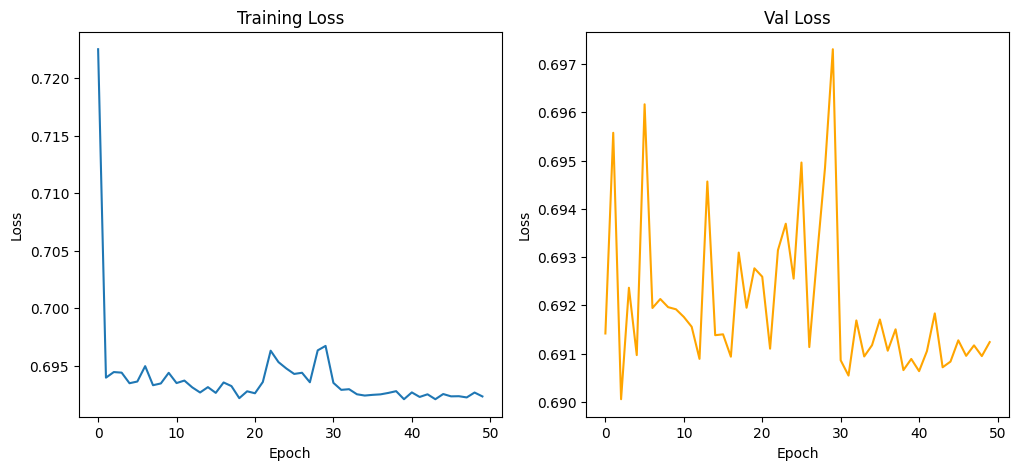

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## 7. Evaluation

In [24]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.5358606557377049
Test accuracy:  0.5489614243323442
